In [1]:
library(SingleCellExperiment)
library(scater)
options(stringsAsFactors = FALSE)

Loading required package: SummarizedExperiment
Loading required package: GenomicRanges
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colMeans, colnames,
    colSums, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, lengths, Map, mapply, match,
    mget, order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rowMeans, rownames, rowSums, sapply, setdiff, sort,
    table, tapply, union, unique, unsp

In [2]:
molecules <- read.table("tung/molecules.txt", sep = "\t")  # UMIs?
anno <- read.table("tung/annotation.txt", sep = "\t", header=TRUE)
# read_counts <- read.table("tung/reads.txt", sep = "\t")    
#head(molecules[,1:3])
head(anno)

individual,replicate,well,batch,sample_id
NA19098,r1,A01,NA19098.r1,NA19098.r1.A01
NA19098,r1,A02,NA19098.r1,NA19098.r1.A02
NA19098,r1,A03,NA19098.r1,NA19098.r1.A03
NA19098,r1,A04,NA19098.r1,NA19098.r1.A04
NA19098,r1,A05,NA19098.r1,NA19098.r1.A05
NA19098,r1,A06,NA19098.r1,NA19098.r1.A06


In [3]:
## Standardise the analysis ##
umi <- SingleCellExperiment(
    assays = list(counts = as.matrix(molecules)),
    colData = anno
)

# First, filter out genes not found in any cell
genes_summed_gt_zero <- rowSums(counts(umi) > 0)
gene_names_gt_zero <- (genes_summed_gt_zero > 0)

umi_filt_genes <- umi[gene_names_gt_zero,]
message("num Genes removed = ", dim(umi) - dim(umi_filt_genes))
umi <- umi_filt_genes

# Second, define control features (genes). 
# - ERCC spike-ins or mitochondrial genes
# This can be defined either from specific gene names

user_spike_samples = c(
    "ENSG00000198899", "ENSG00000198727", "ENSG00000198888",
    "ENSG00000198886", "ENSG00000212907", "ENSG00000198786",
    "ENSG00000198695", "ENSG00000198712", "ENSG00000198804",
    "ENSG00000198763", "ENSG00000228253", "ENSG00000198938", "ENSG00000198840")


# populate a list of feature controls

isSpike(umi, "ERCC")  <- grepl("^ERCC-", rownames(umi))
isSpike(umi, "MT") <- rownames(umi) %in% user_spike_samples

umi <- calculateQCMetrics(umi,       # feature_controls = feat_conts)
    feature_controls = list(
        ERCC = isSpike(umi, "ERCC"), 
        MT = isSpike(umi, "MT")
    )
)

num Genes removed = 3010



FALSE  TRUE 
   46   818 

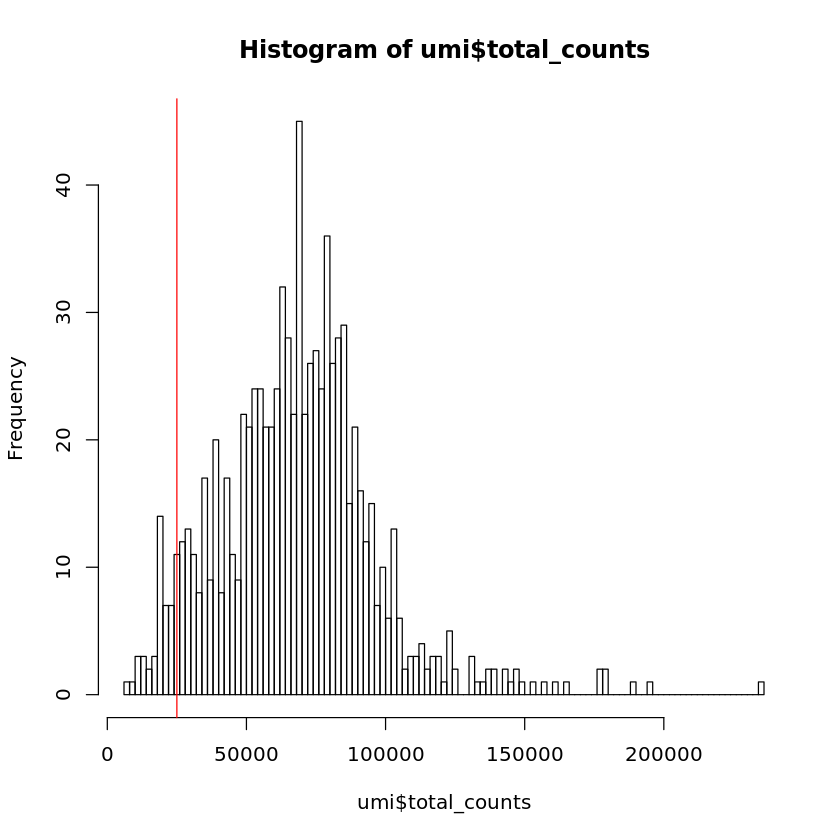

In [4]:
# Cell QC -- we need to decide the size of the library
#  (how many molecules detected per sample).
#
# In the case of UMIs, this is the number of umi counts, as opposed to
#  using the number of read counts.

# Distribution of count numbers assosciated with a given UMI well
# -- we can use this histogram to filter out wells with low read-depths
#    and ensure sufficient 

user_thresh = 25000

hist(umi$total_counts, breaks = 100)
abline(v=user_thresh, col="red")

table(umi$total_counts > user_thresh)

# So we should remove 46 cells with low amount of read-depth


FALSE  TRUE 
  116   748 

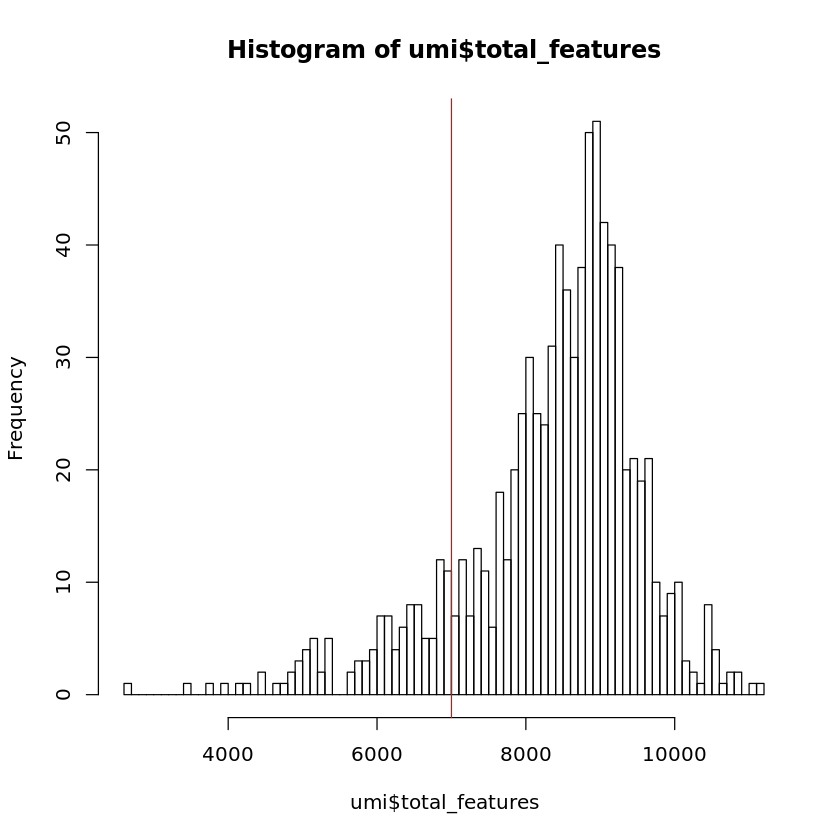

In [5]:
# We can also look at the distribution of unique gene coverage
#  in each sample

# Here we are using high-depth coverage data, so we expect a high level of coverage
#  for all detected genes in our set (this might NOT be that case for rare cell/droplet
#  data).

hist(umi$total_features, breaks = 100)
# From this we can see that most cells have around ~ 7000-10000 genes
#  which is normal for high-depth scRNA-seq.

# we need to make a way to auto-detect this.
autodetected_thresh = 7000
abline(v = autodetected_thresh, col="red")

# CAUTION: This is only true for high-depth scRNA-seq. For lower-depth
#          protocols such as droplet-based that are more tailed for
#          rare cell, we would expect a lower distribution of reads.

table(umi$total_features > autodetected_thresh)


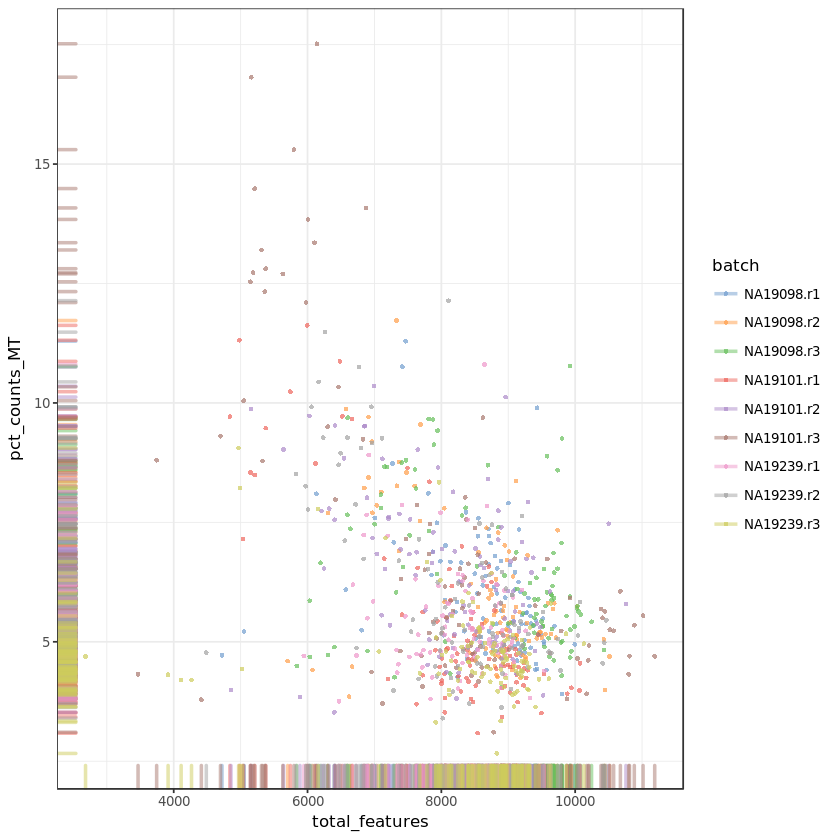

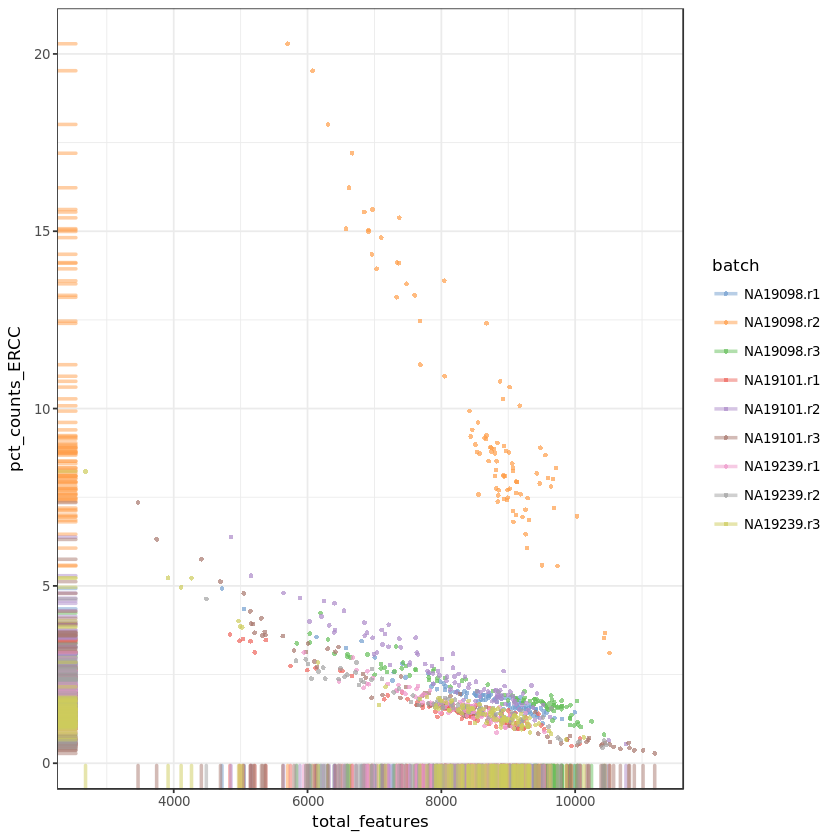

In [6]:
# Final way to measure cell quality is the ratio of ERCC spike-ins in RNA with endogenous RNAs.
# - Quick note: endogenous RNAs are RNAs that regulate other RNAs by competing for 
#               shared microRNAs.

# Cells with a large amount of spike-ins have low starting amounts of RNA, due to the cell
# being dead or stressed which could results in the RNA being degraded.
#
# This is the percentage of counts in the MT genes
plotPhenoData(
    umi,
    aes_string(
        x = "total_features",
        y = "pct_counts_MT",
        colour = "batch"
    )
)

#  This plot below shows that the NA19098.r2 batch of cells a high ratio of ERCC:Endo, which
#  (as confirmed by the authors) indicates that the cells in these batches were stressed and/or
#  were smaller.
#
# This is the percentage of counts in the ERCC control genes
plotPhenoData(
    umi,
    aes_string(
        x = "total_features",
        y = "pct_counts_ERCC",
        colour = "batch"
    )
)

filter_by_ERCC
FALSE  TRUE 
   96   768 

filter_by_MT
FALSE  TRUE 
   31   833 

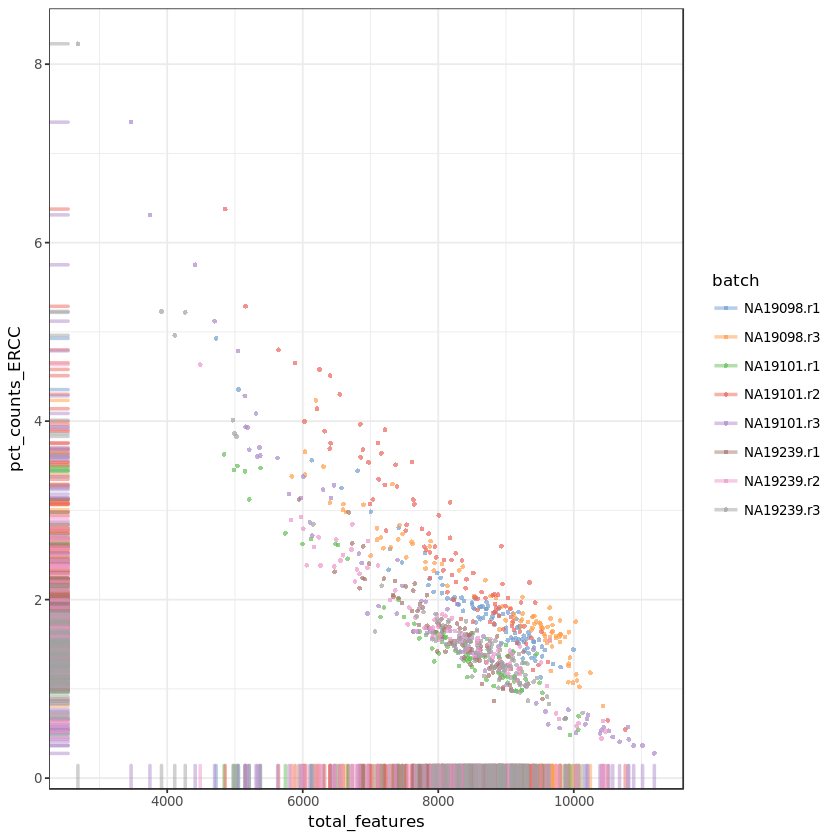

In [7]:
# How many cells do we lose if we filter for those with a high expression of mitochondrial genes
# (>10% of total counts of the cell)?

# We can see that the NA19089.r2 batch have a high ERCC:Endo ratio, and this batch effect was confirmed
# by the authors who said the cells were smaller than normal (and likely degraded).

# How to remove for this batch?
filter_by_ERCC <- umi$batch != "NA19098.r2"
table(filter_by_ERCC)

filter_by_MT <- umi$pct_counts_MT < 10
table(filter_by_MT)

# let's actually apply one of our filters!
plotPhenoData(
    filter(umi, umi$batch != "NA19098.r2"),
    aes_string(
        x = "total_features",
        y = "pct_counts_ERCC",
        colour = "batch"
    )
)

# With the NA1908.r2 batch removed, we can see that the 
# "small/degraded" cell cluster with higher ERCC:Endo ratio is now removed.

# Q? What would happen if we were looking at cells of various different sizes (e.g. normal to senescent ("aged") ?)
# A. You would see different clusters corresponding to different levels of ERCC reads. The normal group would be smaller
#    cells and so would have a higher ERCC read amount, whereas more aged cells would fbe larger and would cluster in
#    lower in the chart.



In [8]:
# Let's now apply all of our filters in one go!

## sufficient features (genes)
filter_by_expr_features <- umi$total_features > 7000

# sufficient molecules counted
filter_by_total_counts <- umi$total_counts > 25000

# sufficient endogenous RNA (ERCC) 
filter_by_ERCC <- umi$batch != "NA19098.r2"

# remove cells with unusual number of reads in MT genes. No more than 10% of MT counts
filter_by_MT <- umi$pct_counts_MT < 10


# create a filter:
umi$use <- ( filter_by_expr_features & filter_by_total_counts & filter_by_ERCC & filter_by_MT )
table(umi$use)




FALSE  TRUE 
  207   657 


FALSE  TRUE 
  819    45 

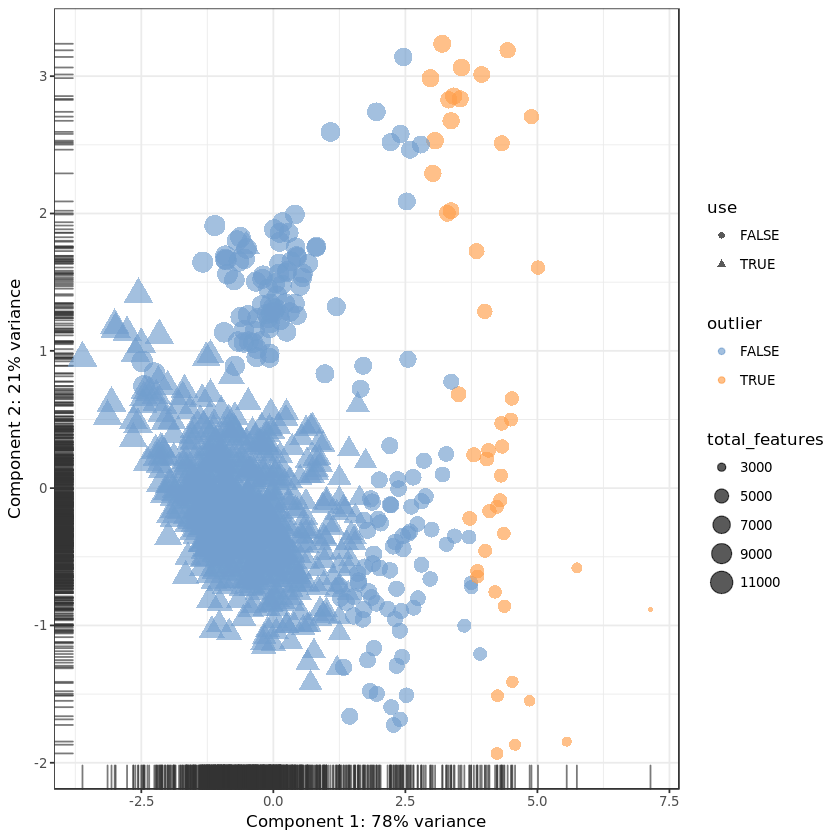

In [13]:
# however! We can do this automatically in SCATER via doing PCAs!
# Use PCA to perform outlier detection for locating problematic cells

# Top singlecellexperiment paramets used in PCA:
#   pct_counts_top_100_features
#   total_features
#   pct_counts_feature_controls
#   n_detected_feature_controls
#   log10_counts_endogenous_features
#   log10_counts_feature_controls

#names(colData(umi))
# Bug: plotPCA throws errors. Add 's' to colData Fix column settings
#umi$total_features_feature_controls <- umi$total_features_feature_control
#umi$log10_total_counts_feature_controls <- umi$log10_total_counts_feature_control
#umi$pct_counts_feature_controls <- umi$pct_counts_feature_control

umi <- plotPCA(
    umi,
    size_by = "total_features", 
    shape_by = "use",
    pca_data_input = "pdata",
    detect_outliers = TRUE,
    return_SCE = TRUE
)
table(umi$outlier)
